In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install numpy scikit-learn
!pip install -q torch_geometric
!pip install -q class_resolver
!pip3 install pymatting
!pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 2.6 MB/s eta 0:00:00


In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
import torch
import torch.nn as nn
import torch.nn.functional as nnFn
import torch.optim as optim
import numpy as np
import random
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import TensorDataset, DataLoader, Subset
from torch_geometric.data import Data

/home/snu/anaconda3/envs/torch_env/lib/python3.10/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /home/snu/anaconda3/envs/torch_env/lib/python3.10/site-packages/libpyg.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/snu/anaconda3/envs/torch_env/lib/python3.10/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/snu/anaconda3/envs/torch_env/lib/python3.10/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSsb
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/snu/anaconda3/envs/torch_env/lib/python3.10/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /home/snu/an

In [7]:
# === Load Patients ===
fa_patients_path = "/home/snu/Downloads/NIFD_Patients_FA_Histogram_Feature.npy"
Patients_FA_array = np.load(fa_patients_path, allow_pickle=True)

# === Load Controls ===
fa_controls_path = "/home/snu/Downloads/NIFD_Control_FA_Histogram_Feature.npy"
Controls_FA_array = np.load(fa_controls_path, allow_pickle=True)

print("Patients Shape:", Patients_FA_array.shape)
print("Controls Shape:", Controls_FA_array.shape)

# === Combine features and labels ===
X = np.vstack([Controls_FA_array, Patients_FA_array])
y = np.hstack([
    np.zeros(Controls_FA_array.shape[0], dtype=np.int64),  # 0 = Control
    np.ones(Patients_FA_array.shape[0], dtype=np.int64)    # 1 = Patient
])

# Shuffle
np.random.seed(42)
perm = np.random.permutation(X.shape[0])
X = X[perm]
y = y[perm]

Patients Shape: (98, 180)
Controls Shape: (48, 180)


In [8]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [9]:
# 20 stratified splits (10% train, 90% test per fold)
sss = StratifiedShuffleSplit(n_splits=20, test_size=0.3, random_state=42)

In [10]:
# Metric storage
accuracies, precisions, recalls, f1_scores, losses = [], [], [], [], []

In [11]:
from sklearn.metrics import log_loss
all_y_true = []
all_y_proba = []
all_fpr = []
all_tpr = []
all_auc = []
# Loop over folds
for fold, (train_idx, test_idx) in enumerate(sss.split(X, y)):
    print(f"\nTraining fold {fold + 1}")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    rf = RandomForestClassifier(n_estimators=200, max_depth=50, random_state=42)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    y_pred_proba = rf.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    loss = log_loss(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    losses.append(loss)
    all_y_true.extend(y_test)
    all_y_proba.extend(y_pred_proba)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(auc_score)

    print(f"Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | Loss: {loss:.4f} | AUC: {auc_score:.4f}")

# Final average results
print("\nAverage Results across 20 folds:")
print(f"Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Cross-Entropy Loss: {np.mean(losses):.4f} ± {np.std(losses):.4f}")
print(f"Average AUC: {np.mean(all_auc):.4f} ± {np.std(all_auc):.4f}")


Training fold 1
Accuracy: 0.7273 | Precision: 0.7500 | Recall: 0.9000 | F1: 0.8182 | Loss: 0.5175 | AUC: 0.7869

Training fold 2
Accuracy: 0.7727 | Precision: 0.7500 | Recall: 1.0000 | F1: 0.8571 | Loss: 0.4703 | AUC: 0.9214

Training fold 3
Accuracy: 0.7045 | Precision: 0.7931 | Recall: 0.7667 | F1: 0.7797 | Loss: 0.5916 | AUC: 0.6857

Training fold 4
Accuracy: 0.6818 | Precision: 0.7222 | Recall: 0.8667 | F1: 0.7879 | Loss: 0.5858 | AUC: 0.6905

Training fold 5
Accuracy: 0.7500 | Precision: 0.7714 | Recall: 0.9000 | F1: 0.8308 | Loss: 0.5183 | AUC: 0.7929

Training fold 6
Accuracy: 0.7045 | Precision: 0.7429 | Recall: 0.8667 | F1: 0.8000 | Loss: 0.5071 | AUC: 0.8155

Training fold 7
Accuracy: 0.7045 | Precision: 0.7429 | Recall: 0.8667 | F1: 0.8000 | Loss: 0.5460 | AUC: 0.7750

Training fold 8
Accuracy: 0.7500 | Precision: 0.7879 | Recall: 0.8667 | F1: 0.8254 | Loss: 0.5329 | AUC: 0.7774

Training fold 9
Accuracy: 0.8182 | Precision: 0.7895 | Recall: 1.0000 | F1: 0.8824 | Loss: 0.44

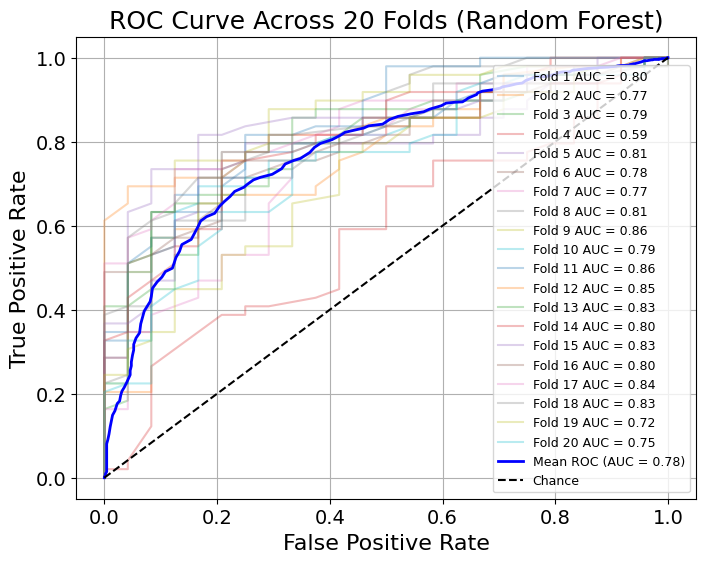

In [ ]:
plt.figure(figsize=(8, 6))

for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], alpha=0.3, label=f"Fold {i+1} AUC = {all_auc[i]:.2f}")

# Average ROC Curve
fpr_avg, tpr_avg, _ = roc_curve(all_y_true, all_y_proba)
auc_avg = roc_auc_score(all_y_true, all_y_proba)
plt.plot(fpr_avg, tpr_avg, color='blue', lw=2, label=f"Mean ROC (AUC = {auc_avg:.2f})")

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.title("ROC Curve Across 20 Folds (Random Forest)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="lower right", fontsize=9)
plt.grid(True)